In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import RMSprop
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import tensorflow as tf
print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)
print(tf.config.list_physical_devices('GPU'))

TF version: 2.5.0
TFP version: 0.13.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


#### Linear Regression with Noisy Data

Suppose we have linear datapoints with some random error, such that,

$$ y_i = x_i + \frac{3}{10}\epsilon_i$$

where $\epsilon_i $ is scattered across Normal distribution $ N(0, 1)$. However, unlike previous article, We'll be running a Bayesian linear regression to capture epitesmic uncertainty of random data.

(100, 1) (100, 1)


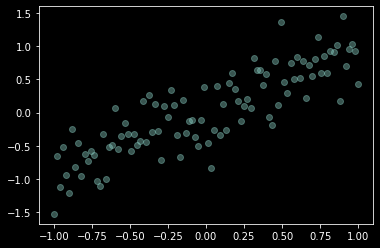

In [2]:
x_train = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train = x_train + 0.3*np.random.randn(100)[:, np.newaxis]

print(x_train.shape, y_train.shape)

plt.scatter(x_train, y_train, alpha=0.4)
plt.show()

#### Create the prior and posterior distribution for model weights

In [5]:

def prior(kernel_size, bias_size, dtype=None):
    # kernel_size : Number of parameters in the dense layer weights matrix
    # bias_size : Number of bias parameters in the dense layer
    # return : Keras model of Distribution of weights in the layer.
    n = kernel_size + bias_size
    
    prior_model = Sequential([
        tfpl.DistributionLambda(
            lambda t: tfd.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag = tf.ones(n))
        )
    ])
    return prior_model
    # notice that the input t isn't used in this distribution. In this example, I'm defining the prior distribution to be the same independent normal distribution regardless of the dense layer input.
    # The prior also has no trainable variables involved at all, it won't change during the optimization procedure.
    


# [정열] [08:10] 아 땡스 그럼 말이 돼네. Diag는 공분산이 0이네
# [김강진] [08:10] 그치그치 맞아! 그럴땐 너가말한대로 각각 뮤 시그마 스칼라 정보라면 충분!
# [정열] [08:15] 위키 진짜 설명 병신이네. 그냥 대각선으로 분산/공분산 넣은거라고 하면 되는데. 그중 스피리컬은 특별하게 다이에그와 달리 x1.x2의 시그마가 같은거고.
# [정열] [08:17] 풀 코바리언스는 분산/공분산조차 제각각이고
# [김강진] [08:57] 맞아맞아 정확해


<tfp.distributions.MultivariateNormalDiag 'MultivariateNormalDiag' batch_shape=[] event_shape=[2] dtype=float32>

In [7]:
# Define variational posterior weight distribution -- multivariate Gaussian

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return Sequential([
        tfpl.VariableLayer(tfpl.MultivariateNormalTriL.params_size(n), dtype = dtype),
        tfpl.MultivariateNormalTriL(n)
        ])

In [8]:
# Create linear regression model with weight uncertainty: weights are
# distributed according to posterior (and, indirectly, prior) distribution

model = Sequential([
    tfpl.DenseVariational(input_shape=(1,),
                        units = 1,
                        make_prior_fn = prior,
                        make_posterior_fn = posterior,
                        kl_weight = 1/x_train.shape[0],
                        kl_use_exact = True
                        )
    ])

model.compile(loss=MeanSquaredError(),optimizer = RMSprop(learning_rate = 0.005))
model.summary()

Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 1)                 5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


#### Train the model

In [9]:
# Fit the model, just like a deterministic linear regression

model.fit(x_train, y_train, epochs=500, verbose=False)

In [10]:
# Check out the parameters of the prior and posterior distribution

dummy_input = np.array([[0]])
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)
print('prior mean:           ', model_prior.mean().numpy())
print('prior variance:       ', model_prior.variance().numpy())
print('posterior mean:       ', model_posterior.mean().numpy())
print('posterior covariance: ', model_posterior.covariance().numpy()[0])
print('                      ', model_posterior.covariance().numpy()[1])

prior mean:            [0. 0.]
prior variance:        [1. 1.]
posterior mean:        [0.91103876 0.01576568]
posterior covariance:  [0.01257125 0.00341997]
                       [0.00341997 0.00587424]


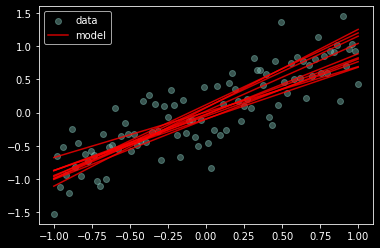

In [12]:
# Plot an ensemble of linear regressions, with weights sampled from
# the posterior distribution

plt.scatter(x_train, y_train, alpha=0.4, label='data')
for _ in range(10):
    y_model = model(x_train)
    if _ == 0:
        plt.plot(x_train, y_model, color='red', alpha=0.8, label='model')
    else:
        plt.plot(x_train, y_model, color='red', alpha=0.8)        
plt.legend()
plt.show()

#### Explore the effect of sample size

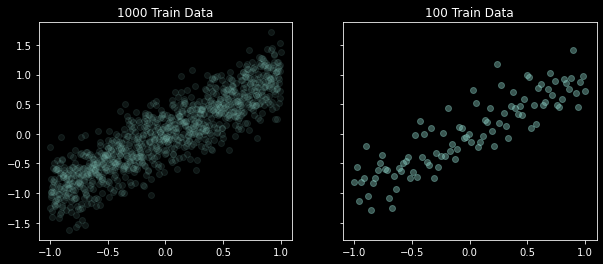

In [14]:
# Create two datasets, one with 1000 points, another with 100

x_train_1000 = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train_1000 = x_train_1000 + 0.3*np.random.randn(1000)[:, np.newaxis]

x_train_100 = np.linspace(-1, 1, 100)[:, np.newaxis]
y_train_100 = x_train_100 + 0.3*np.random.randn(100)[:, np.newaxis]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ax1.scatter(x_train_1000, y_train_1000, alpha=0.1)
ax1.set_title("1000 Train Data")
ax2.scatter(x_train_100, y_train_100, alpha=0.4)
ax2.set_title("100 Train Data")

plt.show()

In [15]:
# Train a model on each dataset

model_1000 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                               units=1,
                                               make_prior_fn=prior, 
                                               make_posterior_fn=posterior,
                                               kl_weight=1/1000)])

model_100 = Sequential([tfpl.DenseVariational(input_shape=(1,), 
                                              units=1,
                                              make_prior_fn=prior, 
                                              make_posterior_fn=posterior,
                                              kl_weight=1/100)])

model_1000.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))
model_100.compile(loss=MeanSquaredError(), optimizer=RMSprop(learning_rate=0.005))

model_1000.fit(x_train_1000, y_train_1000, epochs=50, verbose=False)
model_100.fit(x_train_100, y_train_100, epochs=500, verbose=False)

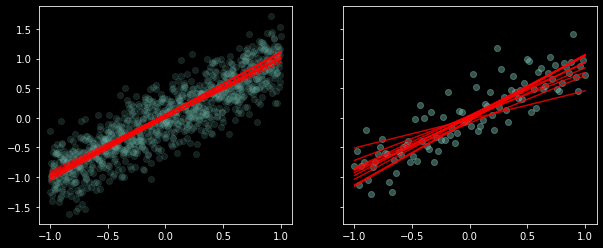

In [16]:
# Plot an ensemble of linear regressions from each model

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for _ in range(10):
    y_model_1000 = model_1000(x_train_1000)
    ax1.scatter(x_train_1000, y_train_1000, color='C0', alpha=0.02)
    ax1.plot(x_train_1000, y_model_1000, color='red', alpha=0.8)
    y_model_100 = model_100(x_train_100)
    ax2.scatter(x_train_100, y_train_100, color='C0', alpha=0.05)
    ax2.plot(x_train_100, y_model_100, color='red', alpha=0.8)
plt.show()

#### Nonlinear probabilistic regression with Epistemic uncertainty

Change learn from non-linear data:

$$ y_i = x_i^3 + \frac{1}{10}(2 + x_i)\epsilon_i$$

where $\epsilon_i \sim N(0, 1)$ are independent and identically distributed.

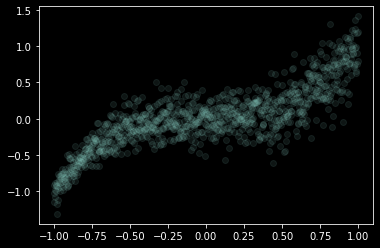

In [17]:
# Create and plot 1000 data points

x_train = np.linspace(-1, 1, 1000)[:, np.newaxis]
y_train = np.power(x_train, 3) + 0.1*(2+x_train)*np.random.randn(1000)[:, np.newaxis]

plt.scatter(x_train, y_train, alpha=0.1)
plt.show()

In [18]:
# Create probabilistic regression with one hidden layer, weight uncertainty

model = Sequential([
    tfpl.DenseVariational(units=8,
                          input_shape=(1,),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0],
                          activation='sigmoid'),
    tfpl.DenseVariational(units=tfpl.IndependentNormal.params_size(1),
                          make_prior_fn=prior,
                          make_posterior_fn=posterior,
                          kl_weight=1/x_train.shape[0]),
    tfpl.IndependentNormal(1)
])

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll, optimizer=RMSprop(learning_rate=0.005))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_3 (DenseVa (None, 8)                 152       
_________________________________________________________________
dense_variational_4 (DenseVa (None, 2)                 189       
_________________________________________________________________
independent_normal (Independ multiple                  0         
Total params: 341
Trainable params: 341
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Train the model

model.fit(x_train, y_train, epochs=100, verbose=False)
model.evaluate(x_train, y_train)

32/32 [==============================] - 1s 8ms/step - loss: 0.5764


0.5764432549476624

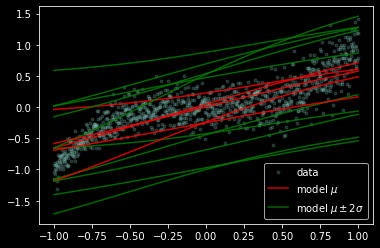

In [20]:
# Plot an ensemble of trained probabilistic regressions

plt.scatter(x_train, y_train, marker='.', alpha=0.2, label='data')
for _ in range(5):
    y_model = model(x_train)
    y_hat = y_model.mean()
    y_hat_m2sd = y_hat - 2 * y_model.stddev()
    y_hat_p2sd = y_hat + 2 * y_model.stddev()
    if _ == 0:
        plt.plot(x_train, y_hat, color='red', alpha=0.8, label='model $\mu$')
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8, label='model $\mu \pm 2 \sigma$')
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)
    else:
        plt.plot(x_train, y_hat, color='red', alpha=0.8)
        plt.plot(x_train, y_hat_m2sd, color='green', alpha=0.8)
        plt.plot(x_train, y_hat_p2sd, color='green', alpha=0.8)        
plt.legend()
plt.show()